<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/AML_IceCores_UMAP_parametric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
from umap.parametric_umap import ParametricUMAP
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
train_size = len(train.labels)
test_size = len(test.labels)

In [6]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

# create encoder training
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
for i in range(nr_ims):
    im, lab, feat = train.__getitem__(i)
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 21s 33ms/step - loss: 0.0370 - val_loss: 0.0127
Epoch 2/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 3/200
282/282 [==============================] - 9s 30ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 4/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0053 - val_loss: 0.0068
Epoch 5/200
282/282 [==============================] - 8s 30ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/200
282/282 [==============================] - 8s 30ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/200
282/282 [==============================] - 8s 30ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/200
282/282 [==============================] - 9s 30ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/200
282/282 [==============================] - 9s 30ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/200
282/282 [==============================] - 9s 31ms/step - loss: 0.00

In [8]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [9]:
encoder_preds_train = encoder.predict(x_train)

In [10]:
tree_encoder_only = lgb.LGBMClassifier(objective='multiclass')
tree_encoder_only.fit(encoder_preds_train, x_train_lab)

LGBMClassifier(objective='multiclass')

In [11]:
# create testing
x_test = []
x_test_lab = []
x_test_feats = []
nr_ims = 10000
for i in range(nr_ims):
    im, lab, feat = test.__getitem__(i)
    x_test.append(im)
    x_test_lab.append(lab)
    x_test_feats.append(feat)
x_test = np.array(x_test)
x_test_lab = np.array(x_test_lab)
x_test_feats = np.array(x_test_feats)

In [12]:
encoder_preds_test = encoder.predict(x_test)
tree_encoder_preds_test = tree_encoder_only.predict(encoder_preds_test)

In [13]:
acc_encoder = sum(tree_encoder_preds_test==x_test_lab)/len(x_test_lab)
acc_encoder

0.7999

In [14]:
embedder = ParametricUMAP()
embedding = embedder.fit_transform(encoder_preds_train)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Epoch 1/10
3493/3493 [==============================] - 28s 7ms/step - loss: 0.2160
Epoch 2/10
3493/3493 [==============================] - 20s 6ms/step - loss: 0.1962
Epoch 3/10
3493/3493 [==============================] - 17s 5ms/step - loss: 0.1907
Epoch 4/10
3493/3493 [==============================] - 17s 5ms/step - loss: 0.1873
Epoch 5/10
3493/3493 [==============================] - 17s 5ms/step - loss: 0.1855
Epoch 6/10
3493/3493 [==============================] - 17s 5ms/step - loss: 0.1831
Epoch 7/10
3493/3493 [==============================] - 17s 5ms/step - loss: 0.1827
Epoch 8/10
3493/3493 [==============================] - 19s 5ms/step - loss: 0.1813
Epoch 9/10
3493/3493 [==============================] - 16s 5ms/step - loss: 0.1803
Epoch 10/10
3493/3493 [==============================] - 16s 5ms/step - loss: 0.1801


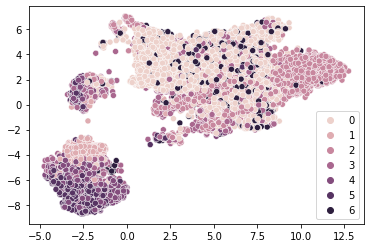

In [15]:
plt.figure()
sb.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue = x_train_lab)
plt.show()

In [19]:
embedding1 = embedder.transform(encoder_preds_test)

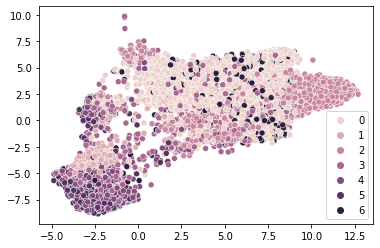

In [20]:
plt.figure()
sb.scatterplot(x=embedding1[:, 0], y=embedding1[:, 1], hue = x_test_lab)
plt.show()